In [17]:
import jax.numpy as jnp
import jax.random as jr
from jax import jit, vmap
import matplotlib.pyplot as plt

import bayes_ca.inference as core
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

In [36]:
@jit
def gibbs_sample_subject_means(key,
                         subj_obs, 
                         sigmasq_obs, 
                         global_means, 
                         sigmasq_subj, 
                         mu_pri, 
                         sigmasq_pri, 
                         hazard_rates):
    num_subjects = subj_obs.shape[0]
    effective_sigmasq = 1 / (1 / sigmasq_obs + 1 / sigmasq_subj)
    effective_emissions = effective_sigmasq * (subj_obs / sigmasq_obs + global_means / sigmasq_subj)

    _sample_one = lambda key, y: core.gaussian_cp_posterior_sample(
        key, y, hazard_rates, mu_pri, sigmasq_pri, effective_sigmasq)[1]
    return vmap(_sample_one)(jr.split(key, num_subjects), effective_emissions)

In [37]:
def _calculate_f_g(mu_0, mu_n):
    """"""
    log_normalizer, _, _, E_mu_n = core.gaussian_cp_smoother(
        mu_0, hazard_rates, mu_pri, sigmasq_pri, sigmasq_subj
    )
    f = -0.5 / sigmasq_subj * jnp.sum((mu_n - mu_0) ** 2) - log_normalizer
    g = 1 / sigmasq_subj * (mu_n - E_mu_n)
    return f, g

In [44]:
key = jr.PRNGKey(0)

# data settings
num_subjects = 2
num_features = 1
num_timesteps = 300

# model settings
num_states = num_timesteps
max_duration = num_states + 1
hazard_prob = 0.01

mu_pri = 0.0
sigmasq_pri = 3.0**2
sigmasq_subj = 0.5
sigmasq_obs = 0.05**2

hazard_rates = hazard_prob * jnp.ones(max_duration)
hazard_rates = hazard_rates.at[-1].set(1.0)

In [45]:
subj_one = jnp.concatenate((
    -1 * jnp.ones((125, num_features)),
    jnp.ones((175, num_features))  
))
subj_two = jnp.concatenate((
    -1 * jnp.ones((175, num_features)),
    jnp.ones((125, num_features))  
))
subj_means = jnp.stack((subj_one, subj_two), axis=0)

global_means = jnp.concatenate((
    -1 * jnp.ones((150, num_features)),
    jnp.ones((150, num_features))  
))

In [46]:
# Finally, sample observations for each subject
this_key, key = jr.split(key)
_sample_one_obs = lambda key: tfd.Normal(subj_means, jnp.sqrt(sigmasq_obs)).sample(seed=key)

_, subj_obs = vmap(_sample_one_obs)(jr.split(this_key, num_subjects))

In [47]:
this_key, key = jr.split(key)
subj_means = gibbs_sample_subject_means(
    key, subj_obs, sigmasq_obs, global_means, sigmasq_subj, mu_pri, sigmasq_pri, hazard_rates)

Text(0, 0.5, '$f$')

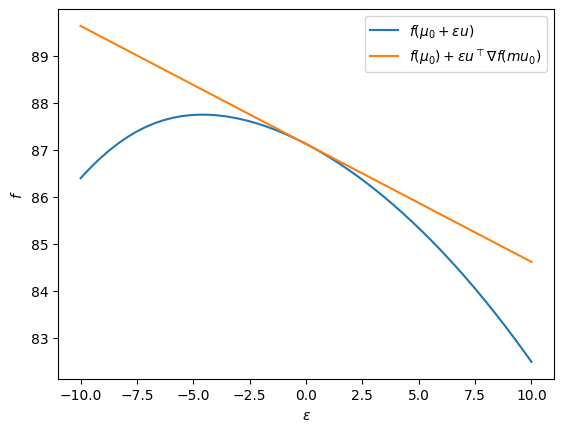

In [50]:
key = jr.PRNGKey(1234)
k1, k2 = jr.split(key, 2)

# Randomly create global and single subject means
# mu0 = jr.normal(k1, (num_timesteps, num_features))
# mun = subj_one

# Use structured global and single subject means
mu0 = global_means
mun = subj_one

# Pick a random direction in which to visualize the gradient
u = jr.normal(k2, (num_timesteps, num_features))
u /= jnp.sqrt(jnp.sum(u**2))

# evaluate the function at a grid of points along this direction
eps = jnp.linspace(-10, 10)
f_true = vmap(lambda e: _calculate_f_g(mu0 + e * u, mun)[0])(eps)

# evaluate the first order taylor approximation along this direction
f0, g0 = _calculate_f_g(mu0, mun)
f_approx = vmap(lambda e: f0 + jnp.sum(e * u * g0))(eps)

plt.plot(eps, f_true, label=r"$f(\mu_0 + \epsilon u)$")
plt.plot(eps, f_approx, label=r"$f(\mu_0) + \epsilon u^\top \nabla f(mu_0)$")
plt.legend()
plt.xlabel(r"$\epsilon$")
plt.ylabel(r"$f$")
